In [106]:
import sys
sys.path.append('..')

sys.path.append("/n/home12/cfpark00/")
import MLtools.src.cuda.tools as cuda_tools

from src import utils

import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import scipy.ndimage as sim

device=cuda_tools.get_freer_device()

memory_available [39774]
best GPU: 0


In [107]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/n/home12/cfpark00/Diffusion/vdm4cdm_dev/vdm4cdm/scripts/../src/utils.py'>

In [108]:
data_source_json="../src/dataset/data_source.json"
data_source=json.load(open(data_source_json))

In [109]:
Mcdm_CMD_file=data_source["CMD"]["IllustrisTNG"]["CV"]["z_0.00"]["Mcdm"]
Mcdm_2df3d_file=data_source["2df3d"]["IllustrisTNG"]["CV"]["z_0.00"]["Mcdm"]
Mcdm_CMD=np.load(Mcdm_CMD_file,mmap_mode="r")
Mcdm_2df3d=np.load(Mcdm_2df3d_file,mmap_mode="r")

In [118]:
smooth=0.0
field_2df3d=Mcdm_2df3d[::15]
field_2df3d=sim.gaussian_filter(field_2df3d,(0,smooth,smooth),mode="wrap")

fields_CMD=torch.tensor(Mcdm_CMD[::15],dtype=torch.float32,device=device).unsqueeze(1)
fields_2df3d=torch.tensor(field_2df3d,dtype=torch.float32,device=device).unsqueeze(1)
fields_CMD_n=fields_CMD/fields_CMD.sum((2,3),keepdim=True)
fields_2df3d_n=fields_2df3d/fields_2df3d.sum((2,3),keepdim=True)
fields_2df3d_n.shape,fields_CMD_n.shape

(torch.Size([27, 1, 256, 256]), torch.Size([27, 1, 256, 256]))

In [119]:
ccs=utils.get_ccs(fields_CMD_n,fields_2df3d_n,full=False).detach().cpu().numpy()
ks,pk_CMD,_=utils.pk(fields_CMD_n)
ks=ks[0].detach().cpu().numpy()
pk_CMD=pk_CMD.detach().cpu().numpy()
pk_2df3d=utils.pk(fields_2df3d_n)[1].detach().cpu().numpy()

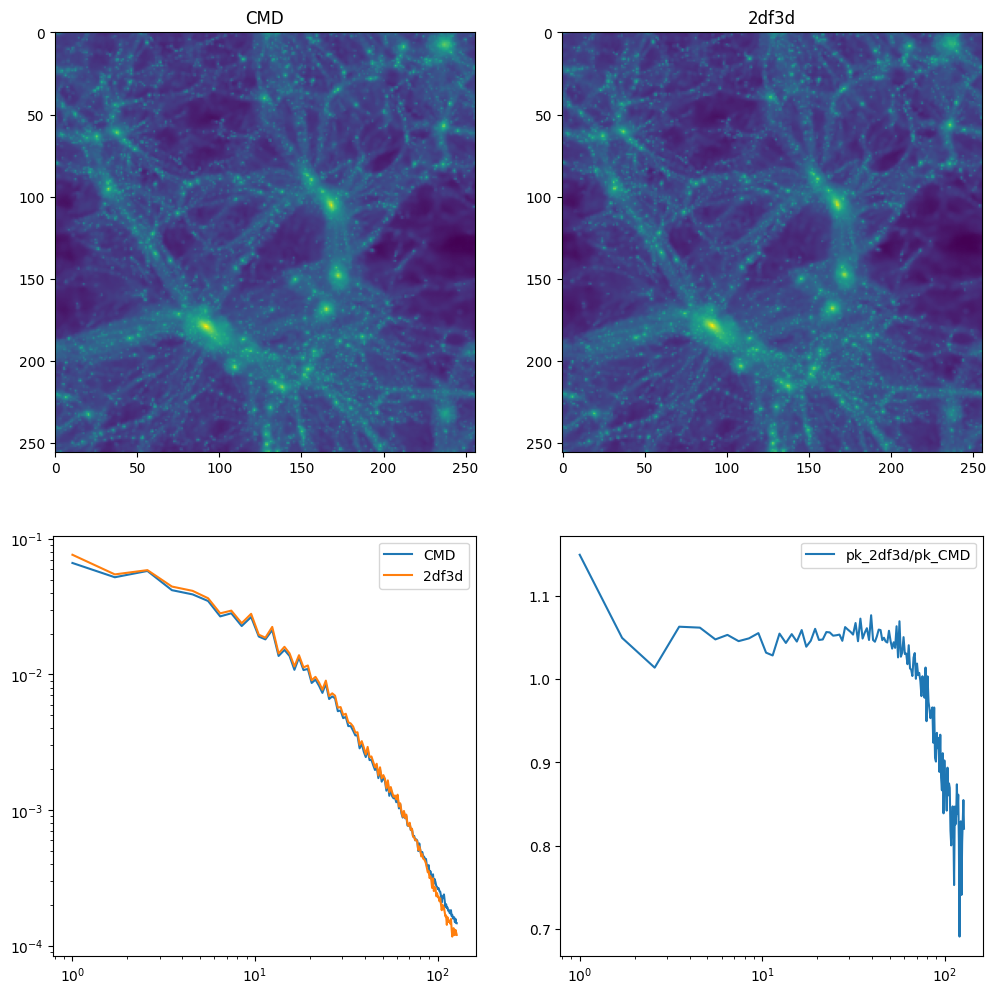

In [120]:
plt.figure(figsize=(12,12))
i=0
plt.subplot(2,2,1)
plt.imshow(np.log10(fields_CMD[i,0].cpu().numpy()))
plt.title("CMD")
plt.subplot(2,2,2)
plt.imshow(np.log10(fields_2df3d[i,0].cpu().numpy()))
plt.title("2df3d")
plt.subplot(2,2,3)
plt.plot(ks,pk_CMD[i],label="CMD")
plt.plot(ks,pk_2df3d[i],label="2df3d")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.subplot(2,2,4)
plt.plot(ks,pk_2df3d[i]/pk_CMD[i],label="pk_2df3d/pk_CMD")
plt.xscale("log")
plt.legend()

In [121]:
m_pk_cmd=pk_CMD.mean(0)
m_pk_cmd.shape

(128,)

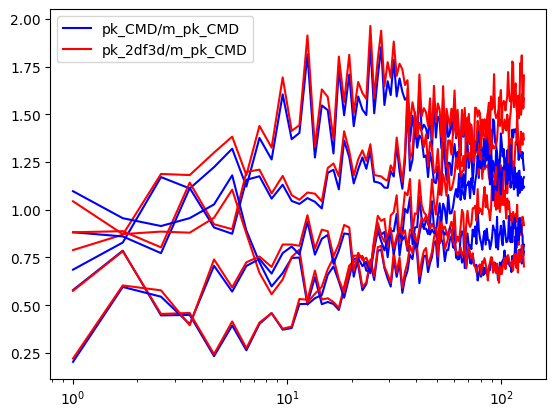

In [123]:
for i in range(5):
    plt.plot(ks,pk_CMD[i]/m_pk_cmd,label=("pk_CMD/m_pk_CMD" if i==0 else ""),c="b")
    plt.plot(ks,pk_2df3d[i]/m_pk_cmd,label=("pk_2df3d/m_pk_CMD" if i==0 else ""),c="r")
plt.xscale("log")
plt.legend()

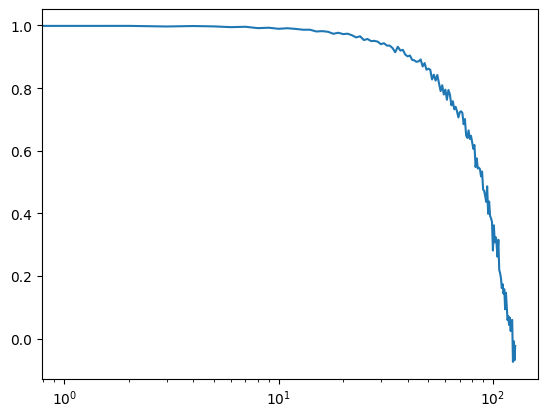

In [71]:
plt.plot(ccs[0,0].cpu().numpy())
plt.xscale("log")

In [60]:
ccs[0,0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [22]:
import numpy as np
import tqdm
import h5py
import json
import os

In [23]:
data_source_json = '../src/dataset/data_source.json'
data_source=json.load(open(data_source_json))

In [24]:
#check all CMD files exists
data_cmd=data_source['CMD']
for suite_name,suite_data in data_cmd.items():
    #print(suite_name)
    for set_name,set_data in suite_data.items():
        #print(set_name)
        for z_name,z_data in set_data.items():
            #print(z_name)
            for field_name,file_path in z_data.items():
                assert os.path.exists(file_path),file_path

In [25]:
data_cmd=data_source['CMD']
norms_cmd={}
for suite_name,suite_data in data_cmd.items():
    norms_cmd[suite_name]={}
    for set_name,set_data in suite_data.items():
        for z_name,z_data in set_data.items():
            for field_name,file_path in z_data.items():
                if set_name=="LH" and z_name=="z_0.00":
                    field=np.load(file_path).astype(np.float64)
                    field_norm=np.log10(field+1)
                    m=field_norm.mean()
                    s=field_norm.std()
                    print(suite_name,field_name,m,s)
                    norms_cmd[suite_name][field_name+"_m"]=m
                    norms_cmd[suite_name][field_name+"_s"]=s

IllustrisTNG Mcdm 10.983874400198474 0.5082524147347647
IllustrisTNG Mstar 0.12069106611776739 1.0848479055157674
Astrid Mcdm 10.98079829583627 0.5086341926985033
Astrid Mstar 0.25111074552799667 1.5009702669376532
SIMBA Mcdm 10.984280942949646 0.5084985199255352
SIMBA Mstar 0.1544203998236156 1.2289904220960028


In [26]:
norms={}
norms["CMD"]=norms_cmd
norms

{'CMD': {'IllustrisTNG': {'Mcdm_m': 10.983874400198474,
   'Mcdm_s': 0.5082524147347647,
   'Mstar_m': 0.12069106611776739,
   'Mstar_s': 1.0848479055157674},
  'Astrid': {'Mcdm_m': 10.98079829583627,
   'Mcdm_s': 0.5086341926985033,
   'Mstar_m': 0.25111074552799667,
   'Mstar_s': 1.5009702669376532},
  'SIMBA': {'Mcdm_m': 10.984280942949646,
   'Mcdm_s': 0.5084985199255352,
   'Mstar_m': 0.1544203998236156,
   'Mstar_s': 1.2289904220960028}}}

In [27]:
#save to json
json_file="../src/dataset/normalizations.json"
json.dump(norms,open(json_file,"w"),indent=2)

In [ ]:
json_file="../src/dataset/normalizations.json"
with open(json_file,"r") as f:
    normalizations = json.load(f)

2D 256

In [2]:
fn="/n/holystore01/LABS/itc_lab/Lab/Camels/2d_from_3d/LH256.h5"

In [3]:
with h5py.File(fn,'r') as h5:
    fields=np.array(h5["mstar_z=0.0"])
print(fields.shape)
fsum=0
sqfsum=0
norm=np.prod(fields.shape)
for i in tqdm.tqdm(range(len(fields))):
    a=torch.log10(torch.tensor(fields[i])+1)
    fsum+=a.sum()
    sqfsum+=(a**2).sum()
mean=fsum/norm
std=torch.sqrt(sqfsum/norm-mean**2)
del fields
"Mstar",mean.item(),std.item()

(15000, 256, 256)


100%|██████████| 15000/15000 [00:01<00:00, 8525.66it/s]


('Mstar', 0.11826974898576736, 1.0741989612579346)

In [4]:
with h5py.File(fn,'r') as h5:
    fields=np.array(h5["mcdm_z=0.0"])
print(fields.shape)
fsum=0
sqfsum=0
norm=np.prod(fields.shape)
for i in tqdm.tqdm(range(len(fields))):
    a=torch.log10(torch.tensor(fields[i]))
    fsum+=a.sum()
    sqfsum+=(a**2).sum()
mean=fsum/norm
std=torch.sqrt(sqfsum/norm-mean**2)
del fields
"Mcdm",mean.item(),std.item()

(15000, 256, 256)


100%|██████████| 15000/15000 [00:01<00:00, 10636.72it/s]


('Mcdm', 10.971004486083984, 0.5090954303741455)

In [6]:
#CMD
lh_2d_256_cdm=np.load("/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy")
lh_2d_256_cdm.shape

(15000, 256, 256)

In [9]:
("Mcdm",np.mean(np.log10(lh_2d_256_cdm)),np.std(np.log10(lh_2d_256_cdm),ddof=0))

('Mcdm', 10.9838705, 0.50825393)

In [10]:
lh_2d_256_star=np.load("/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy")
lh_2d_256_star.shape

(15000, 256, 256)

In [12]:
("Mstar",np.mean(np.log10(lh_2d_256_star+1)),np.std(np.log10(lh_2d_256_star+1),ddof=0))

('Mstar', 0.120691165, 1.0848483)

3D 128

In [20]:
fn="/n/holystore01/LABS/itc_lab/Lab/Camels/3D_grids_128_z/3D_LH_128.h5"

In [21]:
with h5py.File(fn,'r') as h5:
    fields=np.array(h5["mstar_z=0.0"])
print(fields.shape)
fsum=0
sqfsum=0
norm=np.prod(fields.shape)
for i in tqdm.tqdm(range(len(fields))):
    a=torch.log10(torch.tensor(fields[i])+1)
    fsum+=a.sum()
    sqfsum+=(a**2).sum()
mean=fsum/norm
std=torch.sqrt(sqfsum/norm-mean**2)
del fields
"Mstar",mean.item(),std.item()

(1000, 128, 128, 128)


100%|██████████| 1000/1000 [00:05<00:00, 191.93it/s]


('Mstar', 0.018657566979527473, 0.43048593401908875)

In [22]:
with h5py.File(fn,'r') as h5:
    fields=np.array(h5["mcdm_z=0.0"])
print(fields.shape)
fsum=0
sqfsum=0
norm=np.prod(fields.shape)
for i in tqdm.tqdm(range(len(fields))):
    a=torch.log10(torch.tensor(fields[i]))
    fsum+=a.sum()
    sqfsum+=(a**2).sum()
mean=fsum/norm
std=torch.sqrt(sqfsum/norm-mean**2)
del fields
"Mcdm",mean.item(),std.item()

(1000, 128, 128, 128)


100%|██████████| 1000/1000 [00:04<00:00, 249.47it/s]


('Mcdm', 10.046289443969727, 0.5584093332290649)

In [3]:
## random stuff
import numpy as np

In [4]:
mass_mstar = np.load("/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy")
mass_cdm = np.load("/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy")
params=np.loadtxt("/n/holystore01/LABS/itc_lab/Lab/Camels/2D_maps/params_IllustrisTNG.txt")

In [5]:
mass_mstar.shape,mass_cdm.shape,params.shape

((15000, 256, 256), (15000, 256, 256), (1000, 6))